In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt

Loading dataset

In [2]:
path = "zomato.csv"
df = pd.read_csv(path, encoding='latin1', low_memory=False)

In [3]:
print("Shape:", df.shape)

Shape: (9551, 21)


In [4]:
print("Columns:", df.columns.tolist())

Columns: ['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address', 'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines', 'Average Cost for two', 'Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu', 'Price range', 'Aggregate rating', 'Rating color', 'Rating text', 'Votes']


important columns from dataset

In [5]:
name_col = 'Restaurant Name'
cuisines_col = 'Cuisines'
location_col = 'City'
cost_col = 'Average Cost for two'
rate_col = 'Aggregate rating'
votes_col = 'Votes'

Data Cleaning

In [6]:
df = df.dropna(subset=[name_col]).reset_index(drop=True)

In [7]:
df[cuisines_col] = df[cuisines_col].fillna('').astype(str)
df[location_col] = df[location_col].fillna('').astype(str)
df[cost_col] = pd.to_numeric(df[cost_col], errors='coerce')
df[votes_col] = pd.to_numeric(df[votes_col], errors='coerce').fillna(0).astype(int)
df[rate_col] = pd.to_numeric(df[rate_col], errors='coerce')

simplified cuisines

In [8]:
df['cuisines_simple'] = (
    df[cuisines_col]
    .str.lower()
    .str.replace('[^a-z, ]', ' ', regex=True)
    .apply(lambda x: ' '.join([p.strip() for p in x.split(',') if p.strip()][:3]))
)

In [9]:
df['location_simple'] = df[location_col].str.lower().str.replace('[^a-z0-9 ]', ' ', regex=True)
df['name_simple'] = df[name_col].str.lower().str.replace('[^a-z0-9 ]', ' ', regex=True)

made a cost bucket based on pricing

In [10]:
def cost_bucket(x):
    if pd.isna(x): return ''
    x = float(x)
    if x < 300: return 'budget'
    if x < 800: return 'mid'
    return 'premium'

In [11]:
df['cost_bucket'] = df[cost_col].apply(cost_bucket)

Made features of each Restaurant to better describe it

In [12]:
df['features'] = (
    df['cuisines_simple'] + ' ' +
    df['location_simple'] + ' ' +
    df['name_simple'] + ' ' +
    df['cost_bucket']
).str.strip()

print(df[['Restaurant Name', 'features']].head(5))

          Restaurant Name                                           features
0        Le Petit Souffle  french japanese desserts makati city le petit ...
1        Izakaya Kikufuji      japanese makati city izakaya kikufuji premium
2  Heat - Edsa Shangri-La  seafood asian filipino mandaluyong city heat  ...
3                    Ooma       japanese sushi mandaluyong city ooma premium
4             Sambo Kojin  japanese korean mandaluyong city sambo kojin p...


TF-IDF Vectorization

In [13]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=1, stop_words=None)
tfidf_matrix = tfidf.fit_transform(df['features'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(df.index, index=df[name_col].str.lower()).drop_duplicates()

Recommends Restaurants based on TF-IDF Vectorization and Cosine Similarity that we calculated

In [14]:
def recommend_restaurants(name, top_n=10):
    name_key = str(name).lower()
    if name_key not in indices:
        raise ValueError(f"Restaurant '{name}' not found! Try examples: {df[name_col].unique()[:10].tolist()}")

    idx = indices[name_key]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1: top_n+1]
    rec_indices = [i for i, _ in sim_scores]
    rec_scores = [s for _, s in sim_scores]

    recs = df.iloc[rec_indices].copy()
    recs = recs[[name_col, location_col, cuisines_col, rate_col, votes_col]].reset_index(drop=True)
    recs['similarity_score'] = rec_scores
    return recs

In [15]:
seed_restaurant = df[name_col].iloc[0]
print(f"\n Example for: {seed_restaurant}\n")

demo = recommend_restaurants(seed_restaurant, top_n=5)
print(demo)


 Example for: Le Petit Souffle

                       Restaurant Name         City  \
0                     Izakaya Kikufuji  Makati City   
1  Le Petit Cafe - The Lalit New Delhi    New Delhi   
2                              Le Club   Puducherry   
3                Rhubarb Le Restaurant    Singapore   
4           Le Belvedere - Le Meridien    New Delhi   

                            Cuisines  Aggregate rating  Votes  \
0                           Japanese               4.5    591   
1                               Cafe               3.2     31   
2  French, Continental, North Indian               3.5    328   
3                             French               3.9     33   
4                            Chinese               3.5    114   

   similarity_score  
0          0.248465  
1          0.224272  
2          0.113537  
3          0.107418  
4          0.105757  


Visualization

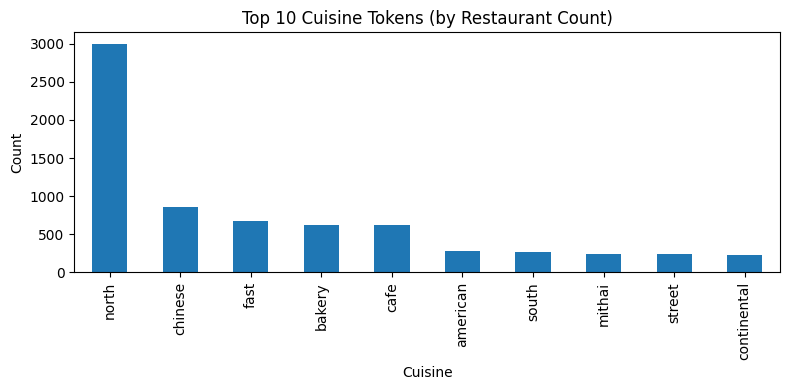

In [16]:
first_token = df['cuisines_simple'].str.split().str[0].fillna('unknown')
top_cuisines = first_token.value_counts().nlargest(10)

plt.figure(figsize=(8, 4))
top_cuisines.plot(kind='bar')
plt.title('Top 10 Cuisine Tokens (by Restaurant Count)')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [17]:
recommend_restaurants('Le Club', top_n=5)

,Restaurant Name,City,Cuisines,Aggregate rating,Votes,similarity_score
0,Le Dupleix,Puducherry,"North Indian, French, Continental",3.8,456,0.471957
1,Le Cafe,Puducherry,Cafe,3.1,875,0.335838
2,#Dilliwaala6,Puducherry,North Indian,3.7,124,0.281078
3,Playboy Club,New Delhi,Finger Food,0.0,3,0.220947
4,China Club,Gurgaon,"Chinese, Asian",3.8,283,0.220040


In [18]:
recommend_restaurants('Ooma', top_n=5)

,Restaurant Name,City,Cuisines,Aggregate rating,Votes,similarity_score
0,Sambo Kojin,Mandaluyong City,"Japanese, Korean",4.8,229,0.281833
1,Din Tai Fung,Mandaluyong City,Chinese,4.4,336,0.245473
2,Sushi Haus,Gurgaon,"Japanese, Sushi",3.8,124,0.235247
3,Fuji Bay Japanese Restaurant,Sioux City,"Japanese, Sushi",3.7,129,0.216701
4,Guppy,New Delhi,"Japanese, Sushi",4.1,665,0.211394


In [43]:
def evaluate_similarity(df, top_n=5):
    scores = []
    for name in df['Restaurant Name'].sample(50, random_state=42):
        try:
            recs = recommend_restaurants(name, top_n=top_n)
            avg_sim = recs['similarity_score'].mean()
            scores.append(avg_sim)
        except:
            continue
    return np.mean(scores)

avg_sim = evaluate_similarity(df)
print("Average Cosine Similarity:", round(avg_sim, 3))

Average Cosine Similarity: 0.317


In [39]:
def precision_at_k(df, top_n=300):
    precisions = []
    for name in df['Restaurant Name'].sample(50, random_state=42):
        try:
            base_cuisine = df.loc[df['Restaurant Name'] == name, 'Cuisines'].iloc[0].split(',')[0].strip().lower()
            recs = recommend_restaurants(name, top_n)
            relevant = recs['Cuisines'].apply(lambda x: base_cuisine in str(x).lower())
            prec = relevant.sum() / top_n
            precisions.append(prec)
        except:
            continue
    return np.mean(precisions)

prec = precision_at_k(df)
print("Precision:", round(prec, 3))

Precision: 0.605


In [33]:
def recall_at_k(df, top_n=300):
    recalls = []
    for name in df['Restaurant Name'].sample(50, random_state=42):
        try:
            base_cuisine = df.loc[df['Restaurant Name'] == name, 'Cuisines'].iloc[0].split(',')[0].strip().lower()
            total_relevant = df['Cuisines'].apply(lambda x: base_cuisine in str(x).lower()).sum() - 1
            recs = recommend_restaurants(name, top_n)
            retrieved_relevant = recs['Cuisines'].apply(lambda x: base_cuisine in str(x).lower()).sum()
            recall = retrieved_relevant / total_relevant if total_relevant > 0 else 0
            recalls.append(recall)
        except:
            continue
    return np.mean(recalls)

rec = recall_at_k(df)
print("Recall:", round(rec, 3))

Recall: 0.309


In [35]:
f1 = (rec * prec * 2) / (rec + prec)
print("F1 Score:", round(f1, 3))

F1 Score: 0.409
